# Data Preprocessing

In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


pd.set_option('display.max_columns', None)
LABEL_COLUMN_NAME = 'label'
SCALE_METHOD = 'standard'
TOP_K = 100

**Utility functions for data preprocessing**

In [126]:
def handle_missing_values_and_duplicates(dataframe):
    print(dataframe.isnull().sum())

    # drop the rows where the target is missing
    dataframe.dropna(subset=[LABEL_COLUMN_NAME], inplace=True)


    # Fill missing values
    for column in dataframe.columns:
        if dataframe[column].dtype == 'object':  # Check if column is string
            dataframe[column] = dataframe[column].fillna(dataframe[column].mode()[0])
        else:  # Otherwise, it's a numeric column
            dataframe[column] = dataframe[column].fillna(dataframe[column].mean())

    #  Drop duplicates
    dataframe.drop_duplicates(inplace=True)

    # Reset the index
    dataframe = dataframe.reset_index(drop=True)


    # Show the number of attributes (columns) and number of records (rows)
    print("Number of attributes: ", dataframe.shape[1])
    print("Number of records: ", dataframe.shape[0])

    return dataframe

In [127]:
def scale_features(features, scaler, columns_to_scale=None):
    if scaler == 'minmax':
        scaler = MinMaxScaler()
    elif scaler == 'standard':
        scaler = StandardScaler()
    else:
        raise ValueError("Invalid scaler")
    
    if columns_to_scale is None:
        return scaler.fit_transform(features)
    else:
        # duplicate the features
        features = features.copy()
        features[columns_to_scale] = scaler.fit_transform(features[columns_to_scale])
        return features

In [128]:
def process_features(dataframe, scaler=SCALE_METHOD):

    features = dataframe.drop(LABEL_COLUMN_NAME, axis=1)

    # get name of columns with datatype object
    object_columns = features.select_dtypes(include=['object']).columns

    # convert the object columns to categorical
    for col in object_columns:
        features[col] = features[col].astype('category')



    columns = features.columns

    
    # drop columns with only one value
    columns_to_drop = [col for col in columns if features[col].nunique() == 1]
    features = features.drop(columns=columns_to_drop)



    # Encoding---------------------------------------------------------

    # columns for label encoding - columns with 2 unique values
    columns_to_label_encode = [col for col in columns if features[col].nunique() == 2]

    # columns for one hot encoding - columns with more than 2 unique values from categorical columns
    categorical_columns = features.select_dtypes(include=['category']).columns
    columns_to_one_hot_encode = [col for col in categorical_columns if features[col].nunique() > 2]


    # columns_to_one_hot_encode = columns_to_one_hot_encode + columns_to_label_encode
    # columns_to_label_encode = []

    # columns to scale - columns  - these three
    columns_to_scale = list(set(columns) - set(columns_to_drop) - set(columns_to_label_encode) - set(columns_to_one_hot_encode))




    # one hot encode columns
    features = pd.get_dummies(features, columns=columns_to_one_hot_encode)

    # label encode columns
    label_encoder = LabelEncoder()
    for col in columns_to_label_encode:
        features[col] = label_encoder.fit_transform(features[col])

    

    # scaling -------------------------------------
    features_scaled = scale_features(features, scaler, columns_to_scale)
    features_df = pd.DataFrame(features_scaled, columns=features.columns)



    print("Columns to drop: ", columns_to_drop)
    print("Columns to label encode: ", columns_to_label_encode)
    print("Columns to one hot encode: ", columns_to_one_hot_encode)
    print("Columns to scale: ", columns_to_scale)

    return features_df

In [129]:
def process_labels(dataframe):
    labels = dataframe[LABEL_COLUMN_NAME]
    
    # label encode the labels
    encoder = LabelEncoder()
    labels = encoder.fit_transform(labels)
    

    # scaled feature dataframe
    labels_df = pd.DataFrame(labels, columns=[LABEL_COLUMN_NAME])

    return labels_df

## Online

In [130]:
DATASET_PATH = '../datasets/online/B1.csv'
LABEL_COLUMN_NAME = 'y'
SCALE_METHOD = 'standard'

dataframe = pd.read_csv(DATASET_PATH)

# Show the number of attributes (columns) and number of records (rows)
print("Number of attributes: ", dataframe.shape[1])
print("Number of records: ", dataframe.shape[0])

dataframe.head()

Number of attributes:  3
Number of records:  3000


,X1,X2,y
0,0.021149,0.418246,1
1,0.173735,-0.993524,0
2,0.251041,0.447588,1
3,0.458603,0.866472,0
4,-0.281439,-0.444892,1


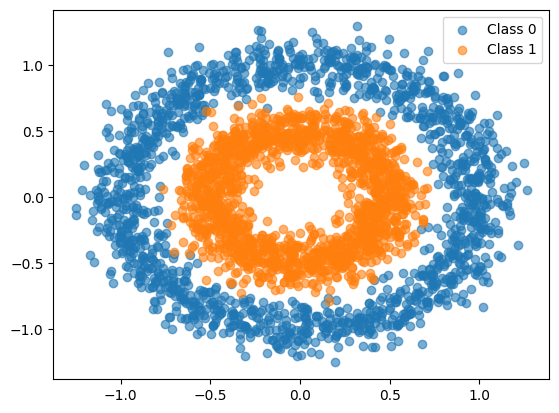

In [131]:
df = dataframe
X = df[['X1', 'X2']].values
y = df['y'].values


# Plot the dataset (optional for visualization)
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], label='Class 0', alpha=0.6)
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], label='Class 1', alpha=0.6)
plt.legend()
plt.show()

In [132]:
dataframe = handle_missing_values_and_duplicates(dataframe)
features_df = process_features(dataframe)
labels_df = process_labels(dataframe)
feature_names = features_df.columns

X1    0
X2    0
y     0
dtype: int64
Number of attributes:  3
Number of records:  3000
Columns to drop:  []
Columns to label encode:  []
Columns to one hot encode:  []
Columns to scale:  ['X2', 'X1']


In [133]:
X = features_df.values
y = labels_df.values.flatten()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Training

From this point on, it is assumed that the data has been preprocessed and partitioned into train, validation and test sets in (X_train, y_train), (X_val, y_val) and (X_test, y_test) respectively.

**Utility Functions**

In [134]:
# Accuracy Sensitivity Specificity Precision F1-score AUROC AUPR
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, average_precision_score
from sklearn.metrics import confusion_matrix

def print_metrics(metrics):
    # Print header
    print(f"{'Metric':<15} {'Value':>10}")
    print("-" * 26)

    # Print each metric
    for name, value in metrics.items():
        print(f"{name:<15} {value:>10.4f}")


def print_mean_metrics(metrics):
    # Print header
    print(f"{'Metric':<15} {'Mean':>10} {'std':>10}")
    print("-" * 38)

    # Print each metric
    for name, value in metrics.items():
        print(f"{name:<15} {value['mean']:>10.4f} {value['std']:>10.4f}")


def print_report_format_metrics(metrics, row_name=""):
    print(row_name, end=" | ")
    for name, value in metrics.items():
        print(f"{value:.4f}", end=" |")
    print()
        

def print_report_format_mean_metrics(metrics, row_name=""):
    # format mean +- std
    print(row_name, end=" | ")
    for name, value in metrics.items():
        print(f"{value['mean']:.4f} ± {value['std']:.4f}", end=" |")
    print()


def get_mean_metrics(metrics_list):
    # calculate avarage and standard deviation of each metric
    metrics = {}
    for name in metrics_list[0].keys():
        values = [m[name] for m in metrics_list]
        metrics[name] = {
            "mean": np.mean(values),
            "std": np.std(values)
        }

    return metrics

def get_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    sensitivity = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)
    aupr = average_precision_score(y_true, y_pred)
    

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn+fp)


    return {
        "Accuracy": accuracy,
        "Sensitivity": sensitivity,
        "Specificity": specificity,
        "Precision": precision,
        "F1-score": f1,
        "AUROC": roc_auc,
        "AUPR": aupr
    }

## Logistic Regression

**Logistic Regression of scikit-learn**

In [135]:
import numpy as np
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
metrics = get_metrics(y_test, y_pred)
print_metrics(metrics)

Metric               Value
--------------------------
Accuracy            0.5350
Sensitivity         0.8051
Specificity         0.3110
Precision           0.4921
F1-score            0.6109
AUROC               0.5581
AUPR                0.4846


**Custom implementation of Logistic Regression**

In [136]:
class CustomLogisticRegression:
    def __init__(self, 
                 learning_rate=0.01, 
                 max_iter=1000,
                 regularization=None,
                 lambda_param=0.001,
                 min_loss_diff=None, 
                 random_state=None, 
                 show_loss_curve=False):
        
        self.learning_rate = learning_rate
        self.n_iters = max_iter
        self.min_loss_diff = min_loss_diff
        self.weights = None
        self.random_state = random_state
        self.show_loss_curve = show_loss_curve
        self.regularization = regularization
        self.lambda_param = lambda_param


    def _sigmoid(self, x):
        # x = np.array(x, dtype=np.float64)
        return np.clip(1 / (1 + np.exp(-x)))
    
    # log likelihood
    def _loss(self, y_pred, y_true):
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        log_loss = -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
        
        if self.regularization == 'l1':
            reg_term = self.lambda_param * np.sum(np.abs(self.weights))
        elif self.regularization == 'l2':
            reg_term = 0.5 * self.lambda_param * np.sum(self.weights**2)
        else:
            reg_term = 0
        
        return log_loss + reg_term


    
    def fit(self, X, y):
        # add 1 to the features
        X = np.hstack((np.ones((X.shape[0], 1)), X))

        X = np.asarray(X, dtype=np.float64)
        y = np.asarray(y, dtype=np.float64)

        n_samples, n_features = X.shape

        
        # Initialize weights
        if self.random_state is not None:
            np.random.seed(self.random_state)
        self.weights = np.random.rand(n_features) * 0.01
        

        calculate_loss = self.show_loss_curve or self.min_loss_diff is not None
        losses = np.zeros(self.n_iters)
        max_iter_reached = 0

        
        for i in range(self.n_iters):
            y_pred = self._sigmoid(X @ self.weights)
            dw = (1 / len(X)) * (X.T @ (y_pred - y))

            # add regularization
            if self.regularization == 'l1':
                dw += self.lambda_param * np.sign(self.weights)
            elif self.regularization == 'l2':
                dw += self.lambda_param * self.weights


            self.weights = self.weights - self.learning_rate * dw

            
        
            if calculate_loss:
                loss = self._loss(y_pred, y)
                losses[i] = loss

                if self.min_loss_diff is not None:
                    if i > 0 and abs(losses[i-1] - losses[i]) < self.min_loss_diff:
                        max_iter_reached = i
                        break
        
        # show loss curve
        if self.show_loss_curve:
            if max_iter_reached > 0:
                plt.plot(range(max_iter_reached), losses[:max_iter_reached])
            else:
                plt.plot(range(self.n_iters), losses)
            plt.xlabel('Iterations')
            plt.ylabel('Loss')
            plt.title('Loss Curve')
            plt.show()


    def predict_proba(self, X):
        X = np.hstack((np.ones((X.shape[0], 1)), X))

        X = np.asarray(X, dtype=np.float64)

        y_pred = self._sigmoid(X @ self.weights)
        return y_pred

    def predict(self, X, threshold=0.5):
        return (self.predict_proba(X) > threshold).astype(int)
            
    

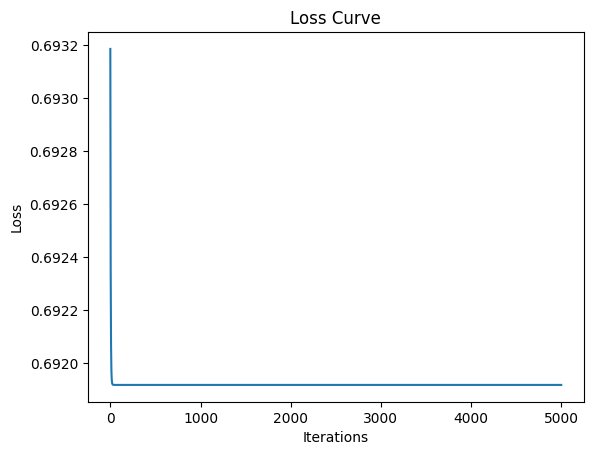

Metric               Value
--------------------------
Accuracy            0.5938
Sensitivity         0.8167
Specificity         0.3708
Precision           0.5648
F1-score            0.6678
AUROC               0.5938
AUPR                0.5530


In [137]:
# Hyperparameters
BASE_LEARNER_REGULARIZATION = 'l2'
BASE_LEARNER_LAMBDA_PARAM = 0.005
BASE_LEARNER_MAX_ITER = 5000
BASE_LEARNER_LEARNING_RATE = 0.5

clf = CustomLogisticRegression(learning_rate=BASE_LEARNER_LEARNING_RATE,
                                max_iter=BASE_LEARNER_MAX_ITER,
                                regularization=BASE_LEARNER_REGULARIZATION,
                                lambda_param=BASE_LEARNER_LAMBDA_PARAM,
                                show_loss_curve=True,
                                random_state=42)
clf.fit(X_train, y_train)

# test on validation and tune hyperparameters
y_pred = clf.predict(X_validation)
metrics = get_metrics(y_validation, y_pred)
print_metrics(metrics)


In [138]:
# test on validation and tune hyperparameters
y_pred = clf.predict(X_test)
metrics = get_metrics(y_test, y_pred)
print_metrics(metrics)

Metric               Value
--------------------------
Accuracy            0.5350
Sensitivity         0.8051
Specificity         0.3110
Precision           0.4921
F1-score            0.6109
AUROC               0.5581
AUPR                0.4846


# Bagging

In [139]:
from sklearn.utils import resample

def generate_bagging_sets(X, y, n_bags, random_state=42):
    np.random.seed(random_state)
    bags = []
    for _ in range(n_bags):
        X_resampled, y_resampled = resample(X, y, n_samples=len(X), replace=True)
        bags.append((X_resampled, y_resampled))
    return bags

In [140]:
bags = generate_bagging_sets(X_train, y_train, n_bags=9, random_state=66)

# Initialize an empty list to store individual classifiers
bagging_classifiers = []

# Train individual classifiers
for x, y in bags:
    # clf = LogisticRegression(random_state=42)
    clf = CustomLogisticRegression(learning_rate=BASE_LEARNER_LEARNING_RATE,
                                   max_iter=BASE_LEARNER_MAX_ITER,
                                   regularization=BASE_LEARNER_REGULARIZATION,
                                   lambda_param=BASE_LEARNER_LAMBDA_PARAM,
                                   random_state=42)
    clf.fit(x, y)
    bagging_classifiers.append(clf)


**Performance of models using voting ensemble**

In [141]:
from scipy import stats

# Make predictions using individual classifiers
y_pred_individual = []
indivisual_metrics = []
for i, clf in enumerate(bagging_classifiers):
    y_pred = clf.predict(X_test)
    y_pred_individual.append(y_pred)
    indivisual_metrics.append(get_metrics(y_test, y_pred))


print("Mean and standard deviation of metrics for individual classifiers")
mean_metrics = get_mean_metrics(indivisual_metrics)
print_mean_metrics(mean_metrics)


# Majority voting using mode
y_pred = stats.mode(y_pred_individual).mode


print("\n\nMetrics for majority voting")
metrics = get_metrics(y_test, y_pred)
print_metrics(metrics)

# for report copypasta
print()
print_report_format_mean_metrics(mean_metrics, "LR")
print_report_format_metrics(metrics, "Voting ensemble")
print()

Mean and standard deviation of metrics for individual classifiers
Metric                Mean        std
--------------------------------------
Accuracy            0.4689     0.0427
Sensitivity         0.7128     0.3080
Specificity         0.2666     0.2217
Precision           0.4131     0.1229
F1-score            0.5138     0.1778
AUROC               0.4897     0.0580
AUPR                0.4558     0.0173


Metrics for majority voting
Metric               Value
--------------------------
Accuracy            0.4600
Sensitivity         0.6875
Specificity         0.2713
Precision           0.4390
F1-score            0.5358
AUROC               0.4794
AUPR                0.4435

LR | 0.4689 ± 0.0427 |0.7128 ± 0.3080 |0.2666 ± 0.2217 |0.4131 ± 0.1229 |0.5138 ± 0.1778 |0.4897 ± 0.0580 |0.4558 ± 0.0173 |
Voting ensemble | 0.4600 |0.6875 |0.2713 |0.4390 |0.5358 |0.4794 |0.4435 |



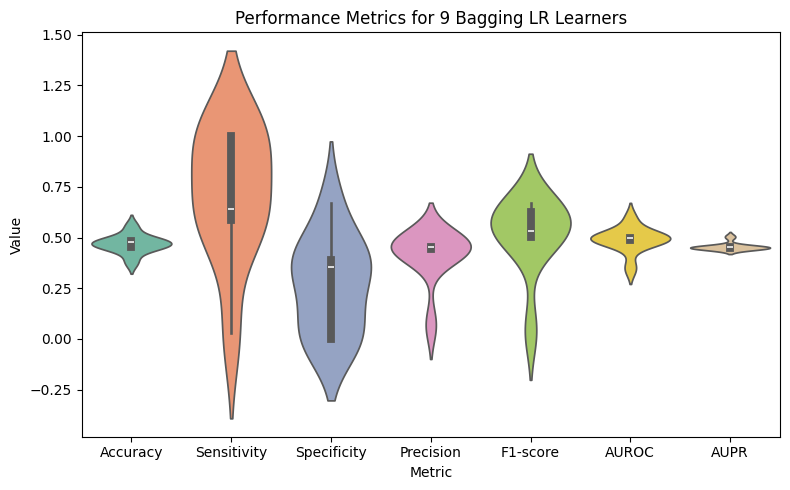

In [142]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(indivisual_metrics)

# Melt the DataFrame to long format
df_melted = df.melt(var_name='Metric', value_name='Value')

# Set a color palette for each metric
palette = sns.color_palette("Set2", len(df_melted['Metric'].unique()))

# Create the violin plot with hue assigned and palette used
plt.figure(figsize=(8, 5))
sns.violinplot(x='Metric', y='Value', data=df_melted, hue='Metric', palette=palette, dodge=False, legend=False)
plt.title('Performance Metrics for 9 Bagging LR Learners')
plt.tight_layout()
plt.show()


# Stacking

**Training the meta model**

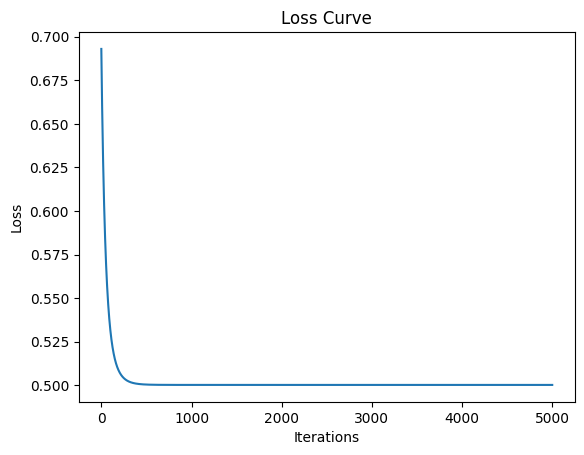

In [143]:
#  predict on validation set using the bagging classifiers
y_pred_validation = np.zeros((X_validation.shape[0], len(bagging_classifiers)))
for i, clf in enumerate(bagging_classifiers):
    y_pred_validation[:,i] = clf.predict(X_validation)


# add previous features with predictions of individual classifiers
stacking_features = np.column_stack((X_validation, y_pred_validation))


# Train a meta-model
# meta_model = LogisticRegression(random_state=42)
meta_model = CustomLogisticRegression(learning_rate=0.5, max_iter=5000, regularization="l2", lambda_param=0.005, show_loss_curve=True, random_state=42)
meta_model.fit(stacking_features, y_validation)


**Performance of models using stacking ensemble**

In [144]:
# prediction of individual classifiers on test set
y_pred_test_bagging = np.zeros((X_test.shape[0], len(bagging_classifiers)))
for i, clf in enumerate(bagging_classifiers):
    y_pred_test_bagging[:,i] = clf.predict(X_test)

# Prepare test data for stacking
stacking_features_test = np.column_stack((X_test,y_pred_test_bagging))


# Make predictions using the meta-model
y_pred = meta_model.predict(stacking_features_test)
metrics = get_metrics(y_test,y_pred)
print_metrics(metrics)



# For report copypasta
print()
print_report_format_metrics(metrics, "Stacking ensemble")


Metric               Value
--------------------------
Accuracy            0.8517
Sensitivity         0.9596
Specificity         0.7622
Precision           0.7699
F1-score            0.8543
AUROC               0.8609
AUPR                0.7571

Stacking ensemble | 0.8517 |0.9596 |0.7622 |0.7699 |0.8543 |0.8609 |0.7571 |
